In [16]:
import sys
sys.path.append("../../")  # If needed, to import your local packages

import torch
import matplotlib.pyplot as plt

from diffusers.models.autoencoders.autoencoder_kl import AutoencoderKL
from diffusers.models.unets.unet_2d_condition import UNet2DConditionModel
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image

# ------------------------------
# Device setup
# ------------------------------
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")
print(f"Using device: {DEVICE}")

# ------------------------------
# Checkpoints
# ------------------------------
UNET_CHECKPOINT = "../../color_diffusion_cond_checkpoints/v2/final_unet.pt"

# ------------------------------
# 1) Load the Stable Diffusion VAE
# ------------------------------
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
vae.eval().to(DEVICE)
for p in vae.parameters():
    p.requires_grad_(False)

# ------------------------------
# 2) Load the Text Encoder + Tokenizer (CLIP)
# ------------------------------
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder")
text_encoder.eval().to(DEVICE)
for p in text_encoder.parameters():
    p.requires_grad_(False)

# ------------------------------
# 3) Create and load the trained UNet2DConditionModel
#    (must match the config used during training)
# ------------------------------
unet = UNet2DConditionModel(
    sample_size=64,
    in_channels=4,
    out_channels=4,
    cross_attention_dim=768,  # must match CLIP hidden size
    layers_per_block=2,
)
unet.load_state_dict(torch.load(UNET_CHECKPOINT, map_location="cpu"))
unet.to(DEVICE)
unet.eval()

# ------------------------------
# 4) Create the scheduler
# ------------------------------
scheduler = DDPMScheduler(num_train_timesteps=1000)

# ------------------------------
# 5) Sampling function (conditional)
# ------------------------------
def sample_images(prompt="a photo of a red color", num_samples=4, num_inference_steps=50):
    unet.eval()
    text_encoder.eval()
    with torch.no_grad():
        # Tokenize the prompt
        text_inputs = tokenizer(
            [prompt] * num_samples,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        ).to(DEVICE)

        # Encode text to get hidden states for cross-attention
        encoder_hidden_states = text_encoder(text_inputs.input_ids).last_hidden_state

        # Start from random noise in latent space
        latents = torch.randn((num_samples, 4, 64, 64), device=DEVICE)
        scheduler.set_timesteps(num_inference_steps)

        for t in scheduler.timesteps:
            # Pass cross-attention conditioning to the UNet
            model_output = unet(
                latents,
                t,
                encoder_hidden_states=encoder_hidden_states
            ).sample

            # Denoise step
            latents = scheduler.step(model_output, t, latents).prev_sample

        # Decode latents into images using the VAE
        images = vae.decode(latents / 0.18215).sample

    # Convert from [-1,1] to [0,1] for display
    images = (images * 0.5 + 0.5).clamp(0, 1)
    return images

Using device: mps


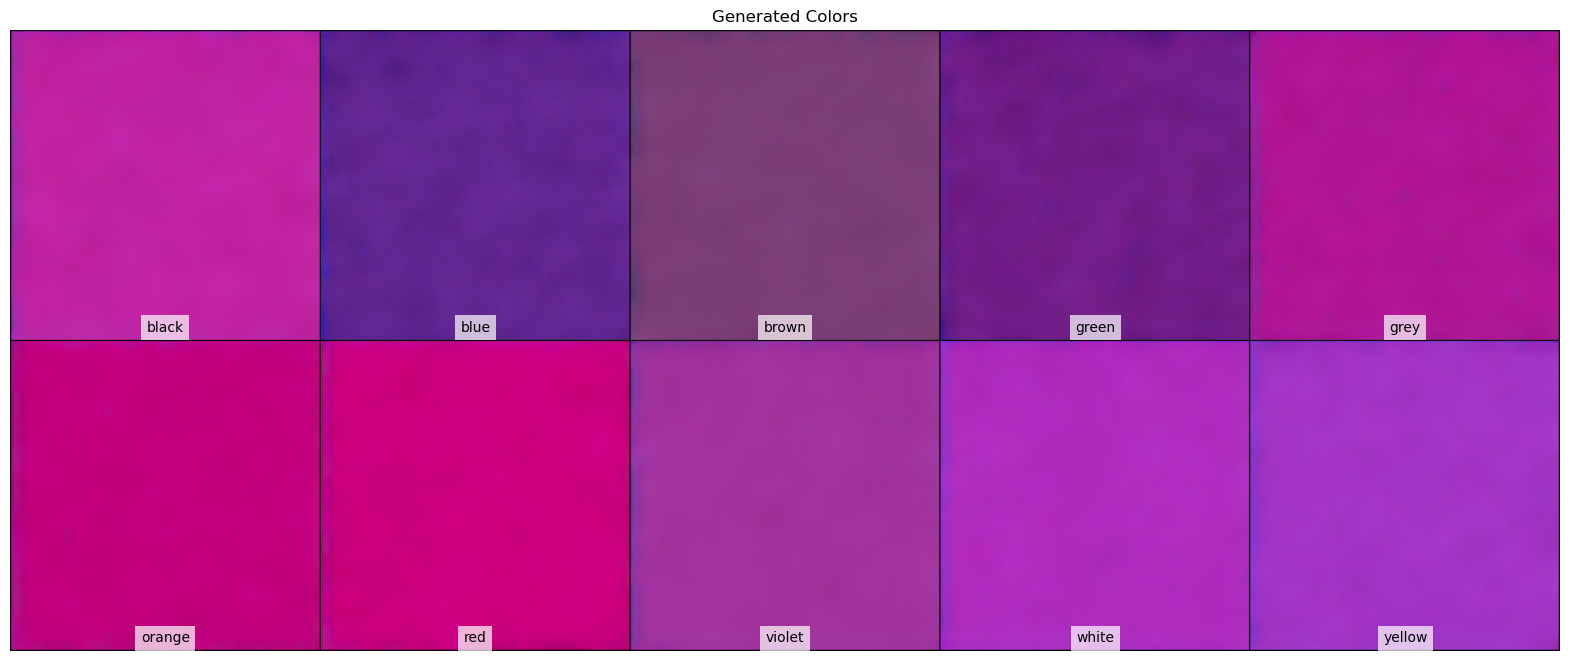

In [17]:
colors = ["black", "blue", "brown", "green", "grey", "orange", "red", "violet", "white", "yellow"]

# Create a list to store all generated images
all_images = []

for color in colors:
    prompt = f"a photo of a {color} color"
    images = sample_images(prompt=prompt, num_samples=1, num_inference_steps=10)
    all_images.append(images[0])  # Add the single generated image to our list

# Combine all images into one grid
combined_grid = make_grid(torch.stack(all_images), nrow=5)  # 5x2 grid for 10 colors
combined_grid_pil = to_pil_image(combined_grid)

# Create a single figure with all colors
plt.figure(figsize=(20, 10))  # Made slightly taller to accommodate text
plt.imshow(combined_grid_pil)

# Add color labels below each image
num_cols = 5
num_rows = len(colors) // num_cols
for idx, color in enumerate(colors):
    row = idx // num_cols
    col = idx % num_cols
    # Calculate x,y positions for text (centered below each image)
    x = col * combined_grid_pil.size[0]/num_cols + combined_grid_pil.size[0]/(num_cols*2)
    y = (row + 1) * combined_grid_pil.size[1]/num_rows - 10  # Slight offset from bottom
    plt.text(x, y, color, ha='center', va='bottom', color='black', 
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.title('Generated Colors')
plt.axis("off")
plt.show()